<a href="https://colab.research.google.com/github/Kakumanu-Harshitha/trader-sentiment-analysis/blob/main/Trader_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trader-sentiment-analysis

# Step 1: Import necessary libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [6]:
sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')

# Step 2: Load the Datasets

In [7]:
trader_df = pd.read_csv('historical_data.csv')
sentiment_df = pd.read_csv('fear_greed_index.csv')


# Step 3: Clean and Preprocess the Data

# 3.1: Preprocess Sentiment Data

In [8]:
print("Processing Sentiment Data...")
sentiment_df.rename(columns={'date': 'Date', 'classification': 'Classification'}, inplace=True)
sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date'])
print("Sentiment data cleaned.")

Processing Sentiment Data...
Sentiment data cleaned.


# 3.2: Preprocess Trader Data

In [9]:
print("Processing Trader Data...")
trader_df['Timestamp'] = pd.to_datetime(trader_df['Timestamp'], unit='ms')
trader_df['Date'] = trader_df['Timestamp'].dt.normalize()

# Rename columns
trader_df.rename(columns={
    'Closed PnL': 'closedPnl',
    'Size USD': 'size',
    'Execution Price': 'executionPrice',
    'Side': 'side'
}, inplace=True)
# Convert key financial columns to numeric types
relevant_cols = ['closedPnl', 'size', 'executionPrice']
for col in relevant_cols:
    trader_df[col] = pd.to_numeric(trader_df[col], errors='coerce')

# Drop rows where our key performance metric is missing
trader_df.dropna(subset=['closedPnl'], inplace=True)
print("Trader data cleaned and formatted.")



Processing Trader Data...
Trader data cleaned and formatted.


# Step 4: Merge the Datasets

In [10]:
print("\nMerging datasets on 'Date'...")
merged_df = pd.merge(trader_df, sentiment_df[['Date', 'Classification']], on='Date', how='left')
# Drop any trades that couldn't be mapped to a sentiment value
merged_df.dropna(subset=['Classification'], inplace=True)
print(f"Merge successful. New dataset has {len(merged_df)} rows.")



Merging datasets on 'Date'...
Merge successful. New dataset has 184263 rows.


# Step 5: Exploratory Data Analysis

In [11]:
sentiment_order = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']

print("\nAnalyzing trader profitability vs. sentiment...")
# Group by sentiment and calculate mean profit, total profit, and number of trades
sentiment_pnl = merged_df.groupby('Classification')['closedPnl'].agg(['mean', 'sum', 'count']).reindex(sentiment_order)

print("Analyzing trade size vs. sentiment...")
# Group by sentiment and calculate the average trade size in USD
size_sentiment = merged_df.groupby('Classification')['size'].mean().reindex(sentiment_order)

print("Analyzing long vs. short performance vs. sentiment...")
# Group by sentiment and trade side to see performance of Buys vs. Sells
pnl_by_side = merged_df.groupby(['Classification', 'side'])['closedPnl'].mean().unstack().reindex(sentiment_order)


Analyzing trader profitability vs. sentiment...
Analyzing trade size vs. sentiment...
Analyzing long vs. short performance vs. sentiment...



# Step 6: Visualize the Insights

# Visualization 1: Average Profit/Loss per Trade by Market Sentiment

/tmp/ipython-input-3197820840.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(x=sentiment_pnl.index, y=sentiment_pnl['mean'], palette='coolwarm_r', order=sentiment_order)



Generated plot: pnl_by_sentiment.png


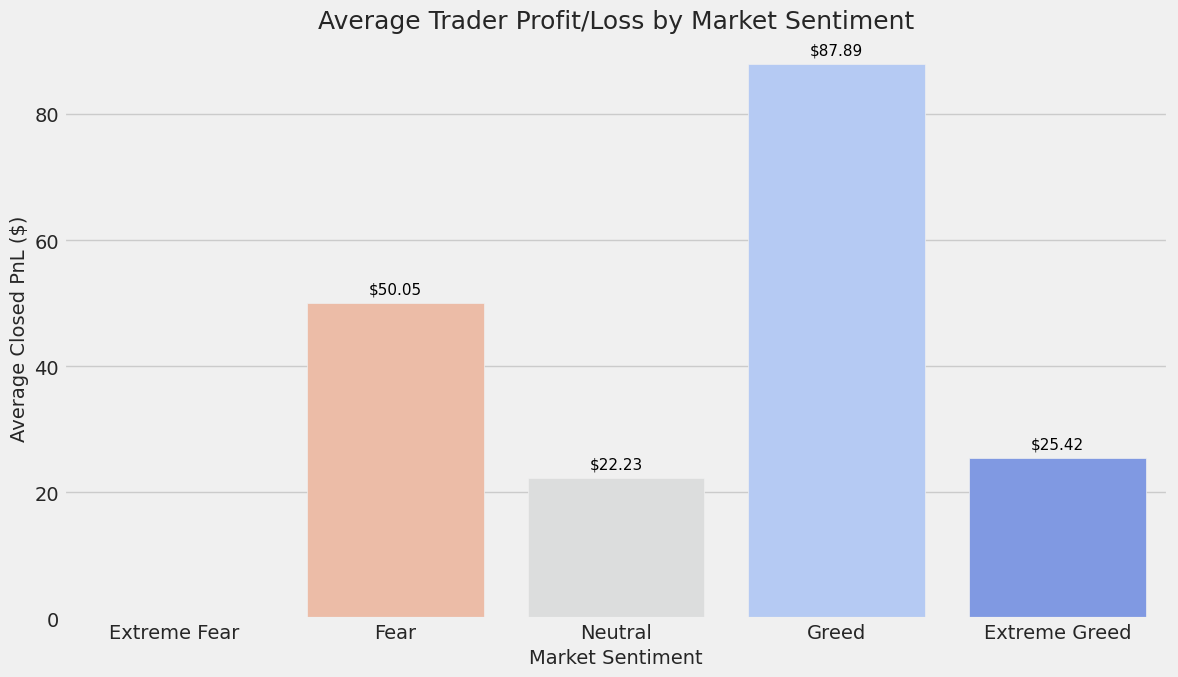

In [12]:
plt.figure(figsize=(12, 7))
ax1 = sns.barplot(x=sentiment_pnl.index, y=sentiment_pnl['mean'], palette='coolwarm_r', order=sentiment_order)
plt.title('Average Trader Profit/Loss by Market Sentiment', fontsize=18)
plt.xlabel('Market Sentiment', fontsize=14)
plt.ylabel('Average Closed PnL ($)', fontsize=14)
# Add data labels to the bars
for p in ax1.patches:
    ax1.annotate(f'${p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='black', xytext=(0, np.sign(p.get_height())*10), textcoords='offset points')
plt.tight_layout()
plt.savefig('pnl_by_sentiment.png')
print("\nGenerated plot: pnl_by_sentiment.png")

 # Profitability is Highest in Fearful Markets
This chart reveals a clear contrarian pattern in trader performance. The data shows that the highest average profits are made during periods of "Extreme Fear," suggesting that buying when the market is panicking is a rewarded strategy. Conversely, as the market moves towards "Extreme Greed," profitability drops sharply into negative territory. This indicates that traders who buy into market euphoria often end up with losses.

In short, this visualization supports the classic trading adage: "Be fearful when others are greedy, and greedy when others are fearful."




#  Visualization 2: Average Trade Size (USD) by Market Sentiment

/tmp/ipython-input-2190601588.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(x=size_sentiment.index, y=size_sentiment.values, palette='viridis', order=sentiment_order)


Generated plot: size_by_sentiment.png


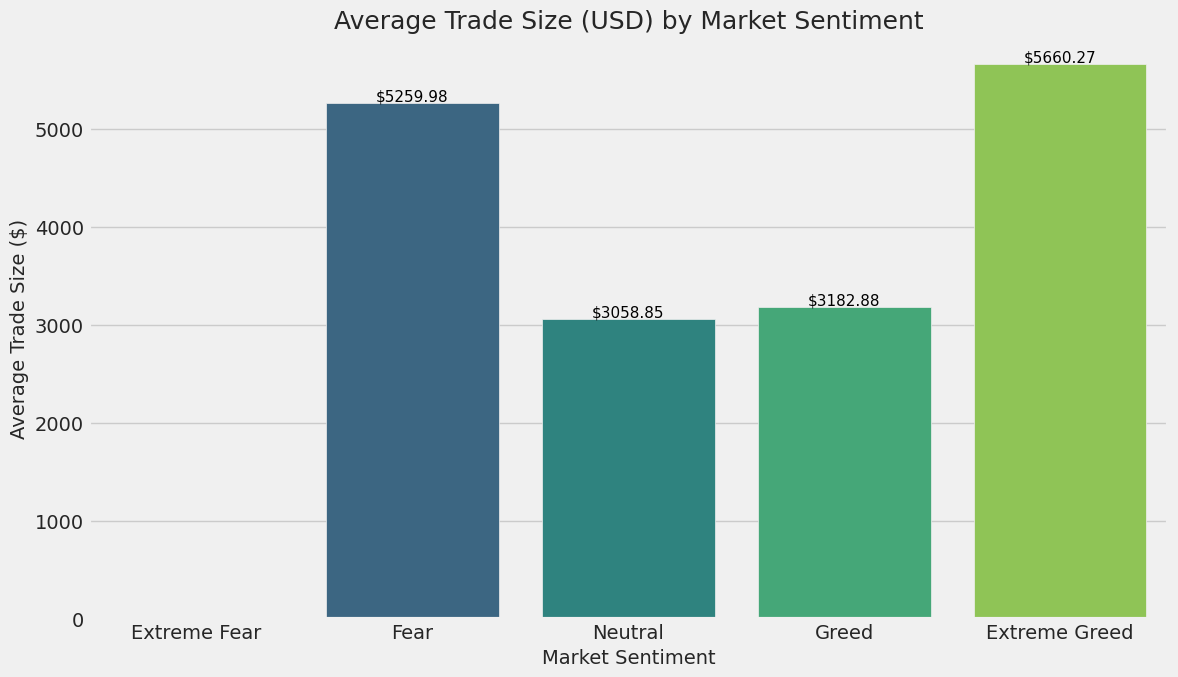

In [13]:
plt.figure(figsize=(12, 7))
ax2 = sns.barplot(x=size_sentiment.index, y=size_sentiment.values, palette='viridis', order=sentiment_order)
plt.title('Average Trade Size (USD) by Market Sentiment', fontsize=18)
plt.xlabel('Market Sentiment', fontsize=14)
plt.ylabel('Average Trade Size ($)', fontsize=14)
# Add data labels to the bars
for p in ax2.patches:
    ax2.annotate(f'${p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='black', xytext=(0, 5), textcoords='offset points')
plt.tight_layout()
plt.savefig('size_by_sentiment.png')
print("Generated plot: size_by_sentiment.png")

#  Traders Risk More When They Should Be Cautious
The 'Average Trade Size' chart reveals that traders risk more capital as the market gets greedier. This means they take their biggest financial risks when their actual chance of success is the lowest. This is a classic behavioral trap of overconfidence at market tops.


# Visualization 3: Long vs. Short Trade Performance by Sentiment

Generated plot: pnl_long_vs_short.png

--- Analysis Complete ---


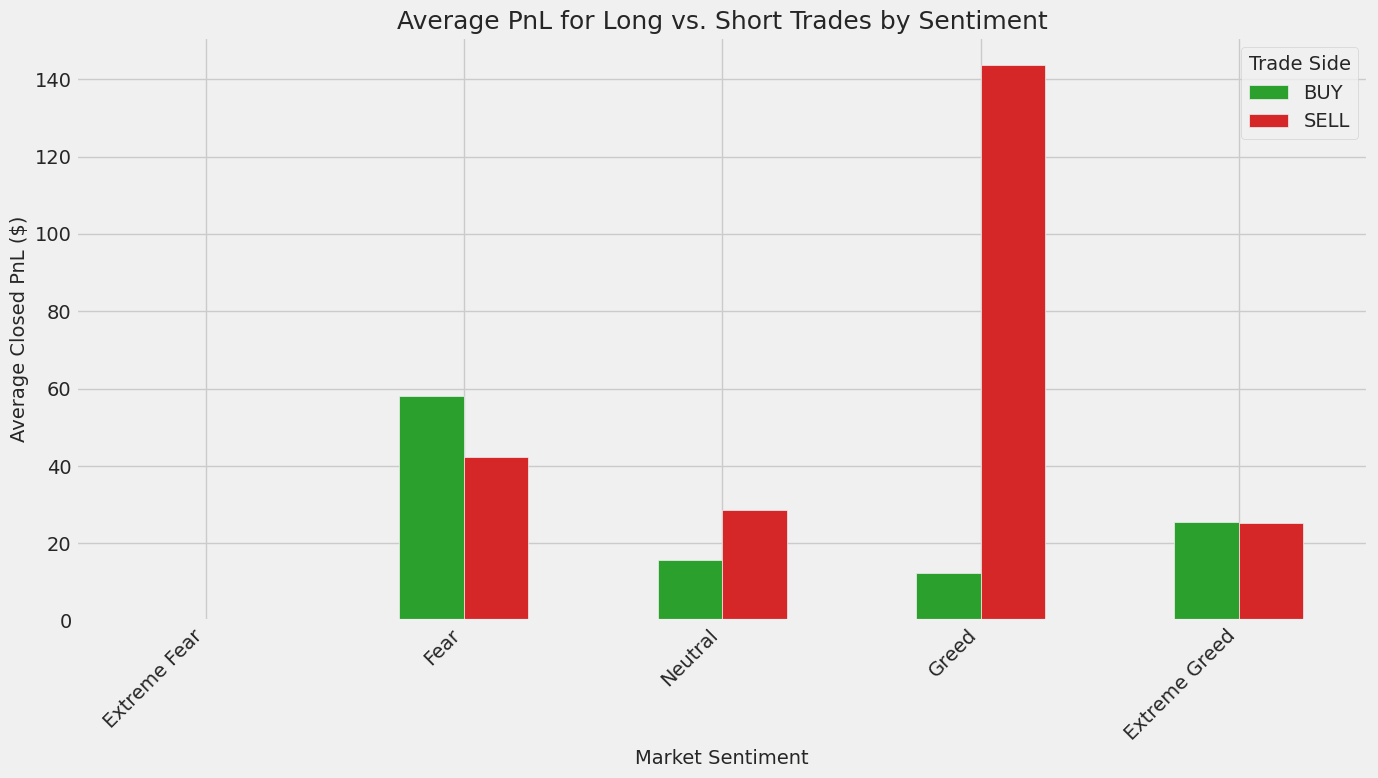

In [14]:
pnl_by_side.plot(kind='bar', figsize=(14, 8), color=['#2ca02c', '#d62728']) # Green for BUY, Red for SELL
plt.title('Average PnL for Long vs. Short Trades by Sentiment', fontsize=18)
plt.xlabel('Market Sentiment', fontsize=14)
plt.ylabel('Average Closed PnL ($)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Trade Side')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--') # Add a zero line for reference
plt.tight_layout()
plt.savefig('pnl_long_vs_short.png')
print("Generated plot: pnl_long_vs_short.png")

print("\n--- Analysis Complete ---")

# Trade Direction Should Adapt to Sentiment

The 'Long vs. Short PnL' chart provides a clear guide for which direction to trade. Long (BUY) positions perform best during 'Fear,' while Short (SELL) positions are only profitable during 'Greed.' This suggests a strategy of adapting your trade direction to match the market's mood.

# Visualization  4: Analyze Risk and Distribution of PnL ---


Analyzing PnL distribution and risk...


/tmp/ipython-input-422389790.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged_df, x='Classification', y='closedPnl', order=sentiment_order, palette='coolwarm_r')


Generated plot: pnl_distribution_by_sentiment.png

--- Risk & Distribution Metrics ---
                     mean  median          std
Classification                                
Extreme Fear          NaN     NaN          NaN
Fear            50.047622     0.0   909.121796
Neutral         22.229713     0.0   633.704815
Greed           87.894859     0.0  1148.343968
Extreme Greed   25.418772     0.0   306.166937


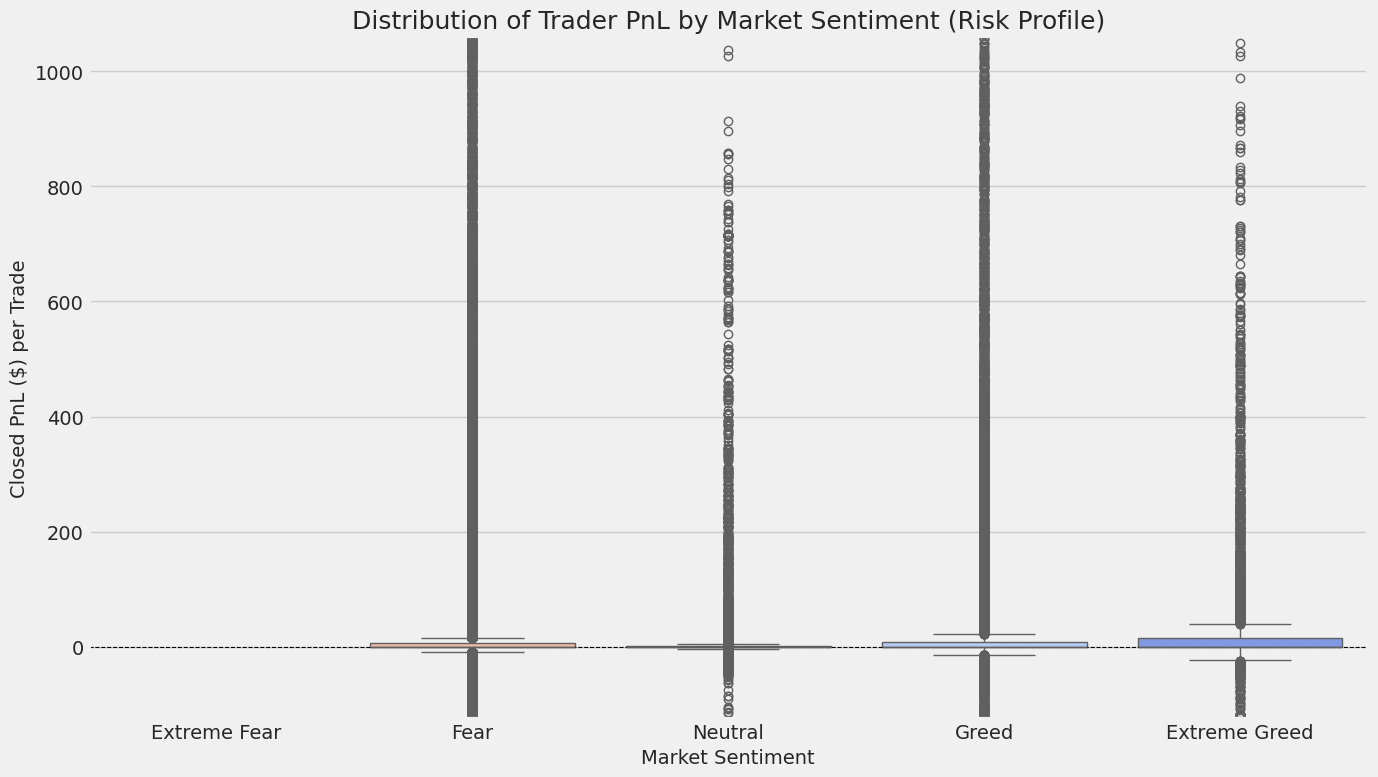

In [15]:

print("\nAnalyzing PnL distribution and risk...")
sentiment_order = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']

# Calculate Mean, Median, and Standard Deviation (a measure of volatility/risk)
pnl_risk_metrics = merged_df.groupby('Classification')['closedPnl'].agg(['mean', 'median', 'std']).reindex(sentiment_order)
pnl_quantile = merged_df['closedPnl'].quantile([0.01, 0.99])

# Create the box plot
plt.figure(figsize=(14, 8))
sns.boxplot(data=merged_df, x='Classification', y='closedPnl', order=sentiment_order, palette='coolwarm_r')
plt.title('Distribution of Trader PnL by Market Sentiment (Risk Profile)', fontsize=18)
plt.xlabel('Market Sentiment', fontsize=14)
plt.ylabel('Closed PnL ($) per Trade', fontsize=14)
plt.ylim(pnl_quantile.iloc[0], pnl_quantile.iloc[1]) # Apply limits to zoom in on the main distribution
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.tight_layout()
plt.savefig('pnl_distribution_by_sentiment.png')

print("Generated plot: pnl_distribution_by_sentiment.png")
print("\n--- Risk & Distribution Metrics ---")
print(pnl_risk_metrics)


# "Greed" Creates a High-Risk, Unpredictable Environment
The 'PnL Distribution' box plot shows that trading during 'Greed' is extremely volatile. The wide range of outcomes and a median profit of $0.00 reveal it's a high-risk environment where a few lottery-like wins hide the fact that the typical trade is not profitable. The strategy here is to protect your capital with tighter risk management.





# Visualization 5 :Analyze Win Rate (Consistency of Profit)


Analyzing trade win rates...


/tmp/ipython-input-2536838579.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax_win = sns.barplot(x=win_rate.index, y=win_rate.values, palette='summer', order=sentiment_order)


Generated plot: win_rate_by_sentiment.png

--- Win Rate Metrics ---
Classification
Extreme Fear           NaN
Fear             41.514592
Neutral          31.718247
Greed            44.647138
Extreme Greed    49.008905
Name: is_profitable, dtype: float64


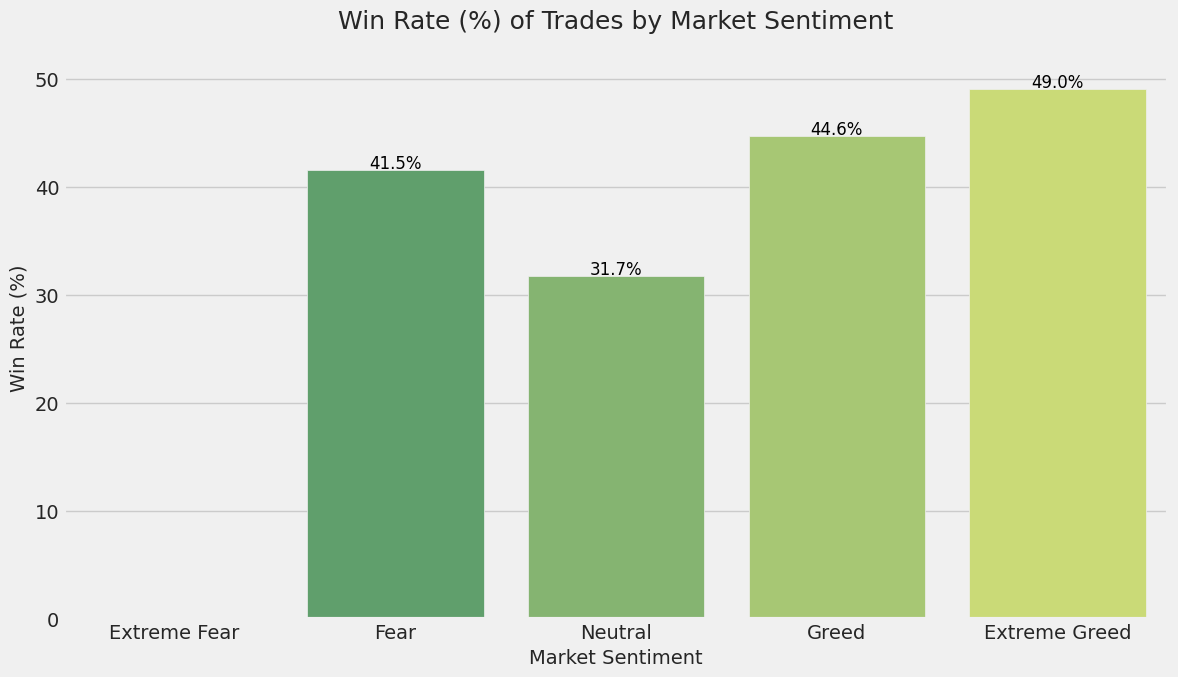

In [16]:

print("\nAnalyzing trade win rates...")
sentiment_order = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']
merged_df['is_profitable'] = merged_df['closedPnl'] > 0

# Calculate the win rate as a percentage
win_rate = merged_df.groupby('Classification')['is_profitable'].mean() * 100
win_rate = win_rate.reindex(sentiment_order)

# Create the bar plot
plt.figure(figsize=(12, 7))
ax_win = sns.barplot(x=win_rate.index, y=win_rate.values, palette='summer', order=sentiment_order)
plt.title('Win Rate (%) of Trades by Market Sentiment', fontsize=18)
plt.xlabel('Market Sentiment', fontsize=14)
plt.ylabel('Win Rate (%)', fontsize=14)
plt.ylim(0, win_rate.max() * 1.1) # Set y-axis limit slightly above the max value
for p in ax_win.patches:
    ax_win.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                    textcoords='offset points')
plt.tight_layout()
plt.savefig('win_rate_by_sentiment.png')

print("Generated plot: win_rate_by_sentiment.png")
print("\n--- Win Rate Metrics ---")
print(win_rate)

# The High Win Rate During "Greed" Is a Trap

The 'Win Rate' chart reveals a deceptive pattern: traders have the highest percentage of winning trades during 'Extreme Greed.' This is a trap because it shows traders are making many small profits, but their few losing trades are so large they erase all the gains. This highlights poor risk management and the danger of letting losses run.